<a href="https://colab.research.google.com/github/trhgquan/CPP/blob/master/code/correction/transformer/transformer_with_custom_metrics_loss_hcm_1m.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q tensorflow==2.10.*

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-transform 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<2.10,>=1.15.5, but you have tensorflow 2.10.0 which is incompatible.
tensorflow-io 0.21.0 requires tensorflow<2.7.0,>=2.6.0, but you have tensorflow 2.10.0 which is incompatible.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, but you have tensorflow-io-gcs-filesystem 0.27.0 which is incompatible.
flax 0.6.0 requires rich~=11.1, but you have rich 12.1.0 which is incompatible.


In [ ]:
%load_ext tensorboard

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import tensorflow as tf
import pickle as pkl
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import plot_model

import logging 
import time

seed = 42

2022-09-25 07:12:27.245951: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-25 07:12:27.414235: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-25 07:12:28.308964: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local

In [ ]:
ls

__notebook__.ipynb


In [ ]:
root = '/kaggle/input'
%cd $root

/kaggle/input


In [ ]:
df = pd.read_csv('dataset-hcm1m/data-hcm-1M.csv')
df

,human_input,address
0,176 Tỉnh Lộ 15 Xã Tân Thạnh Đông Huyện Củ Chi ...,176 Tỉnh Lộ 15 Xã Tân Thạnh Đông Huyện Củ Chi ...
1,176 Tỉnh Lộ 15 Xã Tân Thạnh Đông Huyện Củ Chi ...,176 Tỉnh Lộ 15 Xã Tân Thạnh Đông Huyện Củ Chi ...
2,176 Tỉnh Lộ 115 Xã Tân Thạnh Đông Huyện Củ Chi...,176 Tỉnh Lộ 15 Xã Tân Thạnh Đông Huyện Củ Chi ...
3,176 Tỉnh Lộ 15 Xẫ Tân Thạnh Đông Huyện Củ Chi ...,176 Tỉnh Lộ 15 Xã Tân Thạnh Đông Huyện Củ Chi ...
4,176 Tỉnh Lị6 15 Xã Tân Thạnh Đông Huyện Củ Chi...,176 Tỉnh Lộ 15 Xã Tân Thạnh Đông Huyện Củ Chi ...
...,...,...
999995,237/3A Tôn Thất Thyết Phường 3 Quận 4 TP. Hồ C...,237/3A Tôn Thất Thuyết Phường 3 Quận 4 TP. Hồ ...
999996,237/3A Tôn Thaast Thuyết Phường 3 Quận 4 TP. H...,237/3A Tôn Thất Thuyết Phường 3 Quận 4 TP. Hồ ...
999997,237/3A Tôn Thất Thuyết Ph,237/3A Tôn Thất Thuyết Phường 3 Quận 4 TP. Hồ ...
999998,237/3A Tôn Thất Thuyết Phường 3 Quận 4 TP. Hồ ...,237/3A Tôn Thất Thuyết Phường 3 Quận 4 TP. Hồ ...


In [ ]:
df.columns = ['input','output']
df

,input,output
0,176 Tỉnh Lộ 15 Xã Tân Thạnh Đông Huyện Củ Chi ...,176 Tỉnh Lộ 15 Xã Tân Thạnh Đông Huyện Củ Chi ...
1,176 Tỉnh Lộ 15 Xã Tân Thạnh Đông Huyện Củ Chi ...,176 Tỉnh Lộ 15 Xã Tân Thạnh Đông Huyện Củ Chi ...
2,176 Tỉnh Lộ 115 Xã Tân Thạnh Đông Huyện Củ Chi...,176 Tỉnh Lộ 15 Xã Tân Thạnh Đông Huyện Củ Chi ...
3,176 Tỉnh Lộ 15 Xẫ Tân Thạnh Đông Huyện Củ Chi ...,176 Tỉnh Lộ 15 Xã Tân Thạnh Đông Huyện Củ Chi ...
4,176 Tỉnh Lị6 15 Xã Tân Thạnh Đông Huyện Củ Chi...,176 Tỉnh Lộ 15 Xã Tân Thạnh Đông Huyện Củ Chi ...
...,...,...
999995,237/3A Tôn Thất Thyết Phường 3 Quận 4 TP. Hồ C...,237/3A Tôn Thất Thuyết Phường 3 Quận 4 TP. Hồ ...
999996,237/3A Tôn Thaast Thuyết Phường 3 Quận 4 TP. H...,237/3A Tôn Thất Thuyết Phường 3 Quận 4 TP. Hồ ...
999997,237/3A Tôn Thất Thuyết Ph,237/3A Tôn Thất Thuyết Phường 3 Quận 4 TP. Hồ ...
999998,237/3A Tôn Thất Thuyết Phường 3 Quận 4 TP. Hồ ...,237/3A Tôn Thất Thuyết Phường 3 Quận 4 TP. Hồ ...


## Tokenizer

In [ ]:
start_token = '<s>'
end_token = '<e>'
df['input'] = start_token + ' ' + df['input'].str.lower() + ' ' + end_token
df['output'] = start_token + ' ' + df['output'].str.lower() + ' ' + end_token

In [ ]:
train_df, remain_df = train_test_split(df, test_size = .1, random_state = seed)
val_df, test_df = train_test_split(remain_df, test_size = .5, random_state = seed)
print(f'Shape of train_df: {train_df.shape}')
print(f'Shape of val_df: {val_df.shape}')
print(f'Shape of test_df: {test_df.shape}')

Shape of train_df: (900000, 2)
Shape of val_df: (50000, 2)
Shape of test_df: (50000, 2)


In [ ]:
tokenized_input = Tokenizer(filters = '!"$%&()*+,:;=?@[\\]^_`{|}~\t\n')
tokenized_input.fit_on_texts(train_df.input.apply(str))

tokenized_output = Tokenizer(filters = '!"$%&()*+,:;=?@[\\]^_`{|}~\t\n')
tokenized_output.fit_on_texts(train_df.output.apply(str))

## Dataloader

In [ ]:
class Dataset:
    def __init__(self, data, tokenized_input, tokenized_output, max_len):
        self.input = data["input"].apply(str).values
        self.output = data["output"].apply(str).values

        self.tokenized_input = tokenized_input
        self.tokenized_output = tokenized_output
        self.max_len = max_len
    
    def __getitem__(self, i):
        self.input_sequence = self.tokenized_input.texts_to_sequences([self.input[i]])
        self.output_sequence = self.tokenized_output.texts_to_sequences([self.output[i]])

        self.encoder_input_sequence = pad_sequences(self.input_sequence, padding = "post", maxlen = self.max_len)
        self.decoder_input_sequence = pad_sequences(np.array(self.output_sequence)[:,:-1], padding = "post", maxlen = self.max_len)
        self.decoder_output_sequence = pad_sequences(np.array(self.output_sequence)[:,1:], padding = "post", maxlen = self.max_len)

        return self.encoder_input_sequence, self.decoder_input_sequence, self.decoder_output_sequence
    
    def __len__(self):
        return len(self.encoder_input)

In [ ]:
class Dataloader(tf.keras.utils.Sequence):
    def __init__(self, batch_size, dataset):
        self.dataset = dataset
        self.batch_size = batch_size
        self.total_points = self.dataset.input.shape[0]
    
    def __getitem__(self, i):
        start = i * self.batch_size
        end = (i + 1) * self.batch_size

        batch_encoder = []
        batch_decoder_input = []
        batch_decoder_output = []

        for j in range(start, end):
            encoder, decoder_input, decoder_output = self.dataset[j]

            batch_encoder.append(encoder[0])
            batch_decoder_input.append(decoder_input[0])
            batch_decoder_output.append(decoder_output[0])

        batch_encoder = (np.array(batch_encoder))
        batch_decoder_input = np.array(batch_decoder_input)
        batch_decoder_output = np.array(batch_decoder_output)

        return [batch_encoder, batch_decoder_input], batch_decoder_output
    
    def __len__(self):
        return int(self.total_points / self.batch_size)

In [ ]:
max_token_length = 32 # https://github.com/trhgquan/address-correction-with-ml
BATCH_SIZE = 512

train_dataset = Dataset(data = train_df, tokenized_input = tokenized_input, tokenized_output = tokenized_output, max_len = max_token_length)
train_dataloader = Dataloader(batch_size = BATCH_SIZE, dataset = train_dataset)

val_dataset = Dataset(data = val_df, tokenized_input = tokenized_input, tokenized_output = tokenized_output, max_len = max_token_length)
val_dataloader = Dataloader(batch_size = BATCH_SIZE, dataset = val_dataset)

test_dataset = Dataset(data = test_df, tokenized_input = tokenized_input, tokenized_output = tokenized_output, max_len = max_token_length)
test_dataloader = Dataloader(batch_size = BATCH_SIZE, dataset = test_dataset)

## Positional Encoding

In [ ]:
def positional_encoding(length,depth):
    depth = depth/2
    
    positions = np.arange(length)[:,np.newaxis]
    depths = np.arange(depth)[np.newaxis, :]/depth

    angle_rates = 1/(10000**depths)
    angle_rads = positions * angle_rates

    pos_encoding = np.concatenate([np.sin(angle_rads),np.cos(angle_rads)], axis=-1)
    return pos_encoding.astype('float32')

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self,vocab_size,d_model):
        super().__init__()
        self.d_model=d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero = True)
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def compute_mask(self,*args,**kwargs):
        return self.embedding.compute_mask(*args,*kwargs)

    def call(self,x):
        length = x.shape[1]
        x = self.embedding(x)
        x *= np.sqrt(float(self.d_model))
        x += self.pos_encoding[np.newaxis, :length, :]
        return x

In [ ]:
# For testing
embed_input = PositionalEmbedding(vocab_size=len(tokenized_input.word_index), d_model=512)
embed_output = PositionalEmbedding(vocab_size=len(tokenized_output.word_index), d_model=512)

input_emb = embed_input(train_dataloader[0][0][0])
output_emb = embed_output(train_dataloader[0][0][1])

print(output_emb._keras_mask)

tf.Tensor(
[[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 ...
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]], shape=(512, 32), dtype=bool)


2022-09-25 07:13:17.713952: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-25 07:13:17.807088: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-25 07:13:17.807898: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-25 07:13:17.809089: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

## Feed-forward network

In [ ]:
def point_wise_feed_forward_network(
    d_model, # Input/output dimensionality
    dff, # Inner-layer dimensionality
    ):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff,activation='relu'), # Shape (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model) # Shape (batch_size, seq_len, d_model)
    ])

In [ ]:
# For testing
sample_ffn = point_wise_feed_forward_network(512, 2048)

# Print the shape.
print(sample_ffn(np.random.uniform(size = (64, 50, 512))).shape)

(64, 50, 512)


## Encoder

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,*,
                 d_model, # Input/output dimensionality
                 num_attention_heads,
                 dff, # Inner-layer dimensionality
                 dropout_rate=.1
                 ):
        super().__init__()

        # Multi-head self-attention
        self.mha = tf.keras.layers.MultiHeadAttention(
            num_heads = num_attention_heads,
            key_dim = d_model,
            dropout = dropout_rate,
        )
        # Point-wise feed-forward network
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        # Layer normalization
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        # Dropout for the point-wise feed-forward network
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, training, mask):
        # A boolean mask
        if mask is not None:
            mask1 = mask[:, :, None]
            mask2 = mask[:, None, :]
            attention_mask = mask1 & mask2
        else:
            attention_mask = None
        
        # Multi-head self-attention output
        attn_output = self.mha(
            query = x, # Query Q tensor
            value = x, # Query V tensor
            key = x, # Key K tensor
            attention_mask = attention_mask, # A boolean mask that prevents attention to certain positions
            training = training, # A boolean indicating whether the layer should behave in training mode
        )

        # Multi-head self-attention output after layer normalization and a residual/skip connection
        out1 = self.layernorm1(x + attn_output)

        # Point-wise feed-forward network output
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout1(ffn_output, training = training)
        # Point-wise feed-forward network output after layer normalization and a residual/skip connection
        out2 = self.layernorm2(out1 + ffn_output)
        return out2

In [ ]:
# For testing 
sample_encoder_layer = EncoderLayer(d_model=512, num_attention_heads=8, dff=2048)

sample_encoder_layer_output = sample_encoder_layer(
    np.random.uniform(size=(2, 3, 512)), training=False, mask=None)

# Print the shape.
print(sample_encoder_layer_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(2, 3, 512)


In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self,
                 *,
                 num_layers,
                 d_model, # Input/output dimensionality
                 num_attention_heads,
                 dff, # Inner-layer dimensionality
                 input_vocab_size, # Input vocabulary size
                 dropout_rate = .1
                 ):
        super().__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        # Embedding + Positional encoding
        self.pos_embedding = PositionalEmbedding(input_vocab_size, d_model)

        # Encoder layers
        self.enc_layers = [
            EncoderLayer(
                d_model = d_model,
                num_attention_heads = num_attention_heads,
                dff = dff,
                dropout_rate = dropout_rate)
            for _ in range(num_layers)
        ]
        # Dropout
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
    
    # Masking 
    def compute_mask(self,x, previous_mask = None):
        return self.pos_embedding.compute_mask(x, previous_mask)
    
    def call(self, x, training):
        seq_len = x.shape[1]
        
        # Sum up embeddings and positional encoding
        mask = self.compute_mask(x)
        x = self.pos_embedding(x) # Shape (batch_size, input_seq_len, d_model)
        # Add dropout
        x = self.dropout(x, training = training)

        # N encoder layers
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        return x # Shape (batch_size, input_seq_len, d_model)

In [ ]:
# For testing
# Instantiate the encoder.
sample_encoder = Encoder(
    num_layers=2,
    d_model=512,
    num_attention_heads=8,
    dff=2048,
    input_vocab_size=len(tokenized_input.word_index))

# Set the test input.
sample_encoder_output = sample_encoder(train_dataloader[3][0][0],
                                       training=False)

# Print the shape.
print(train_dataloader[3][0][0].shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(512, 32)
(512, 32, 512)


## Decoder

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self,
                 *,
                 d_model, # Input/output dimensionality
                 num_attention_heads,
                 dff, # Inner-layer dimensionality
                 dropout_rate=.1
                 ):
        super().__init__()

        # Mask multi-head self-attention
        self.mha_masked = tf.keras.layers.MultiHeadAttention(
            num_heads = num_attention_heads,
            key_dim = d_model, # Size of each attention head for query Q and key K
            dropout = dropout_rate
        )
        # Multi-head cross-attention
        self.mha_cross = tf.keras.layers.MultiHeadAttention(
            num_heads = num_attention_heads,
            key_dim = d_model, # Size of each attentionhead for query Q and key K
            dropout = dropout_rate
        )

        # Point-wise feed-forward network
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        # Layer normalization
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        # Dropout for the point-wise feed-forward network
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, mask, enc_output, enc_mask, training):
        # The encoder output shape is (batch_size, input_seq_len, d_model)
        
        # A boolean mask
        self_attention_mask = None
        if mask is not None:
            mask1 = mask[:, :, None]
            mask2 = mask[:, None, :]
            self_attention_mask = mask1 & mask2
        
        # Masked multi-head self-attention output (tf.keras.layers.MultiHeadAttention)
        attn_masked, attn_weights_masked = self.mha_masked(
            query = x,
            value = x, 
            key = x,
            attention_mask = self_attention_mask, # A boolean mask that prevents attention to certain positions
            use_causal_mask = True, # A boolean to indicate whether to apply a causal mask to prevent tokens from attending to future tokens
            return_attention_scores = True, # Shape (batch_size, target_seq_len, d_model)
            training = training # A boolean indicating whether the layer should behave in training mode
        )

        # Masked multi-head self-attention output after layer normalization and a residual/skip connection
        out1 = self.layernorm1(attn_masked + x)

        # A boolean mask 
        attention_mask = None
        if mask is not None and enc_mask is not None:
            mask1 = mask[:, :, None]
            mask2 = enc_mask[:, None, :]
            attention_mask = mask1 & mask2
        
        # Multi-head cross-attention output (tf.keras.layers.MultiHeadAttention)
        attn_cross, attn_weights_cross = self.mha_cross(
            query = out1,
            value = enc_output,
            key = enc_output,
            attention_mask = attention_mask, # A boolean mask that prevents attention to certain positions
            return_attention_scores = True, # Shape (batch_size, target_seq_len, d_model)
            training = training # A boolean indicating whether the layer should behave in training mode 
        )

        # Multi-head cross-attention output after layer normalization and a residual/skip connection
        out2 = self.layernorm2(attn_cross + out1)

        # Point-wise feed-forward network output
        ffn_output = self.ffn(out2) # Shape (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout1(ffn_output, training = training)
        out3 = self.layernorm3(ffn_output + out2) # Shape (batch_size, target_seq_len, d_model)

        return out3, attn_weights_masked, attn_weights_cross

In [ ]:
# For testing
sample_decoder_layer = DecoderLayer(d_model=512, num_attention_heads=8, dff=2048)

sample_decoder_layer_output, att1, att2 = sample_decoder_layer(
    x=np.random.uniform(size=(2, 5, 512)),
    mask=None,
    enc_output=sample_encoder_layer_output,
    enc_mask=None,
    training=False)

# Print the shape.
print(sample_decoder_layer_output.shape)  # `(batch_size, target_seq_len, d_model)`

(2, 5, 512)


In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self,
                 *,
                 num_layers,
                 d_model, # Input/output dimensionality
                 num_attention_heads,
                 dff, # Inner-layer dimensionality
                 target_vocab_size,
                 dropout_rate = .1
                 ):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(target_vocab_size,d_model)

        self.dec_layers = [
            DecoderLayer(
                d_model = d_model,
                num_attention_heads = num_attention_heads,
                dff = dff,
                dropout_rate = dropout_rate
            )
            for _ in range(num_layers)
        ]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, enc_output, enc_mask, training):
        attention_weights = {}

        mask = self.pos_embedding.compute_mask(x)
        x = self.pos_embedding(x) # Shape (batch_size, target_seq_len, d_model)

        x = self.dropout(x, training = training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, mask, enc_output, enc_mask, training)

            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2
        
        # The shape of x is (batch_size, target_seq_len, d_model)
        return x, attention_weights

## Hyperparameter

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_attention_heads = 8
dropout_rate = 0.1

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self,
               *,
               num_layers, # Number of decoder layers.
               d_model, # Input/output dimensionality.
               num_attention_heads,
               dff, # Inner-layer dimensionality.
               input_vocab_size, # Input (Portuguese) vocabulary size.
               target_vocab_size, # Target (English) vocabulary size.
               dropout_rate=0.1
               ):
        super().__init__()
        # The encoder.
        self.encoder = Encoder(
            num_layers=num_layers,
            d_model=d_model,
            num_attention_heads=num_attention_heads,
            dff=dff,
            input_vocab_size=input_vocab_size,
            dropout_rate=dropout_rate
            )

        # The decoder.
        self.decoder = Decoder(
            num_layers=num_layers,
            d_model=d_model,
            num_attention_heads=num_attention_heads,
            dff=dff,
            target_vocab_size=target_vocab_size,
            dropout_rate=dropout_rate
            )

        # The final linear layer.
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inputs, training):
        # Keras models prefer if you pass all your inputs in the first argument.
        # Portuguese is used as the input (`inp`) language.
        # English is the target (`tar`) language.
        inp, tar = inputs

        # The encoder output.
        enc_output = self.encoder(inp, training)  # `(batch_size, inp_seq_len, d_model)`
        enc_mask = self.encoder.compute_mask(inp)

        # The decoder output.
        dec_output, attention_weights = self.decoder(
            tar, enc_output, enc_mask, training)  # `(batch_size, tar_seq_len, d_model)`

        # The final linear layer output.
        final_output = self.final_layer(dec_output)  # Shape `(batch_size, tar_seq_len, target_vocab_size)`.

        # Return the final output and the attention weights.
        return final_output#, attention_weights

## Combine all layer and training

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(tf.cast(step, dtype=tf.float32))
        arg2 = tf.cast(step, dtype=tf.float32) * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

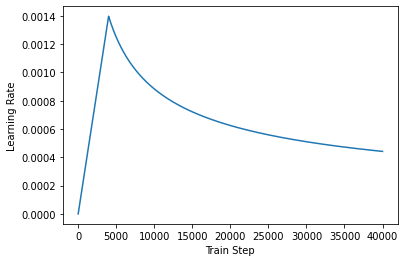

In [ ]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [ ]:
encoder_input = layers.Input(
    shape = (max_token_length)
)
encoder = Encoder(
            num_layers = num_layers,
            d_model = d_model,
            num_attention_heads = num_attention_heads,
            dff = dff,
            input_vocab_size = len(tokenized_input.word_index)+1,
            dropout_rate = dropout_rate
        )
enc_output = encoder(encoder_input, True)  # Shape `(batch_size, inp_seq_len, d_model)`
enc_mask = encoder.compute_mask(encoder_input)

decoder_input = layers.Input(
    shape = (max_token_length)
)
decoder = Decoder(
            num_layers = num_layers,
            d_model = d_model,
            num_attention_heads = num_attention_heads,
            dff = dff,
            target_vocab_size = len(tokenized_output.word_index)+1,
            dropout_rate = dropout_rate
        )
# The decoder output.
dec_output, attention_weights = decoder(
    decoder_input, enc_output, enc_mask, True)  # Shape `(batch_size, tar_seq_len, d_model)`

# The final linear layer output.
final_output = layers.Dense(
    len(tokenized_output.word_index)+1,
    # activation = "softmax"
)(dec_output)

model = Model(
    inputs = [encoder_input, decoder_input],
    outputs = final_output
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 encoder_1 (Encoder)            (None, 32, 128)      9585664     ['input_1[0][0]']                
                                                                                                  
 tf.math.not_equal (TFOpLambda)  (None, 32)          0           ['input_1[0][0]']                
                                                                                              

In [ ]:
from datetime import datetime
model_save = "/kaggle/working/transformer_hcm_1m.h5"
log_dir = '/kaggle/working/logs/fit/' + datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath = model_save,
        save_best_only = True,
        mode = "min",
        save_weights_only = True
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor = "val_loss",
        patience = 5,
        verbose = 1,
        min_delta = .0001
    ),
    tensorboard_callback
]
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)
def accuracy_function(real, pred):
    accuracies = tf.equal(tf.cast(real,dtype=tf.int64), tf.argmax(pred, axis=2))

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)
model.compile(
    optimizer = optimizer,
    loss = loss_function,
    metrics = [accuracy_function, "accuracy"]
)

train_steps = train_dataloader.__len__()
val_steps = val_dataloader.__len__()

In [ ]:
hist = model.fit(
    train_dataloader,
    steps_per_epoch = train_steps,
    epochs = 100,
    validation_data = val_dataloader,
    validation_steps = val_steps,
    callbacks = callbacks
)

Epoch 1/100


/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:1563: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1757/1757 [==============================] - ETA: 0s - loss: 2.1840 - accuracy_function: 0.8068 - accuracy: 0.3667

2022-09-25 07:27:23.346798: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1667235840 exceeds 10% of free system memory.
2022-09-25 07:27:25.840208: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 373370880 exceeds 10% of free system memory.
2022-09-25 07:27:27.201245: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 373370880 exceeds 10% of free system memory.


1757/1757 [==============================] - 844s 474ms/step - loss: 2.1840 - accuracy_function: 0.8068 - accuracy: 0.3667 - val_loss: 0.1575 - val_accuracy_function: 0.9776 - val_accuracy: 0.4444
Epoch 2/100
1757/1757 [==============================] - ETA: 0s - loss: 0.0785 - accuracy_function: 0.9882 - accuracy: 0.4492

2022-09-25 07:41:14.598290: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1667235840 exceeds 10% of free system memory.
2022-09-25 07:41:16.915443: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 373370880 exceeds 10% of free system memory.


1757/1757 [==============================] - 831s 473ms/step - loss: 0.0785 - accuracy_function: 0.9882 - accuracy: 0.4492 - val_loss: 0.0464 - val_accuracy_function: 0.9929 - val_accuracy: 0.4514
Epoch 3/100
1757/1757 [==============================] - 830s 473ms/step - loss: 0.0346 - accuracy_function: 0.9939 - accuracy: 0.4517 - val_loss: 0.0411 - val_accuracy_function: 0.9938 - val_accuracy: 0.4518
Epoch 4/100
1757/1757 [==============================] - 831s 473ms/step - loss: 0.0256 - accuracy_function: 0.9952 - accuracy: 0.4523 - val_loss: 0.0361 - val_accuracy_function: 0.9945 - val_accuracy: 0.4521
Epoch 5/100
1757/1757 [==============================] - 831s 473ms/step - loss: 0.0212 - accuracy_function: 0.9961 - accuracy: 0.4528 - val_loss: 0.0357 - val_accuracy_function: 0.9946 - val_accuracy: 0.4522
Epoch 6/100
1757/1757 [==============================] - 831s 473ms/step - loss: 0.0189 - accuracy_function: 0.9965 - accuracy: 0.4530 - val_loss: 0.0355 - val_accuracy_functio

In [ ]:
model.evaluate(test_dataloader)

97/97 [==============================] - 22s 221ms/step - loss: 0.0360 - accuracy_function: 0.9949 - accuracy: 0.4522


[0.03603358939290047, 0.9949320554733276, 0.45221325755119324]

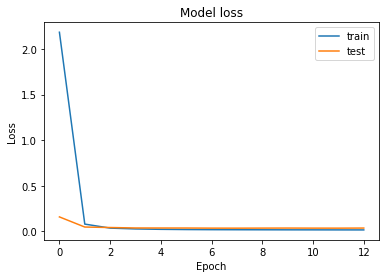

In [ ]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.title("Model loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "test"], loc = "upper right")
plt.show()

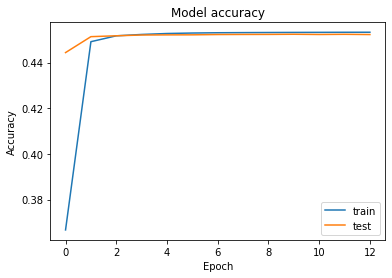

In [ ]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.title("Model accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "test"], loc = "lower right")
plt.show()

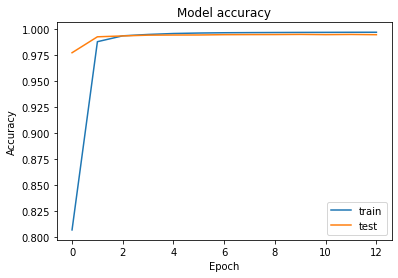

In [ ]:
plt.plot(hist.history["accuracy_function"])
plt.plot(hist.history["val_accuracy_function"])
plt.title("Model accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "test"], loc = "lower right")
plt.show()

## Predict some input

In [ ]:
class Translator(tf.Module):
    def __init__(self, tokenized_input, tokenized_output, transformer):
        self.tokenized_input = tokenized_input
        self.tokenized_output = tokenized_output
        self.transformer = transformer

    def __call__(self, sentence, max_length=max_token_length):
        # The input sentence is Portuguese, hence adding the `[START]` and `[END]` tokens.
#         assert isinstance(sentence, tf.Tensor)
#         if len(sentence.shape) == 0:
#             sentence = sentence[tf.newaxis]
        sequence = tokenized_input.texts_to_sequences(['<s> '+sentence+' <e>'])

        encoder_input = pad_sequences(
            sequence,
            maxlen = max_length,
            padding = "post"
        )
        predict_sequence = []
#         sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

#         encoder_input = sentence

        # As the output language is English, initialize the output with the
        # English `[START]` token.
#         start_end = self.tokenizers.en.tokenize([''])[0]
#         start = start_end[0][tf.newaxis]
#         end = start_end[1][tf.newaxis]
        start = tokenized_output.texts_to_sequences(['<s>'])[0]
        end = tokenized_output.texts_to_sequences(['<e>'])[0]

        # `tf.TensorArray` is required here (instead of a Python list), so that the
        # dynamic-loop can be traced by `tf.function`.
        output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
        output_array = output_array.write(0, start)

        for i in tf.range(max_length):
            output = tf.transpose(output_array.stack())
#             predictions, _ = self.transformer([encoder_input, output], training=False)
            enc_output = self.transformer.layers[2](encoder_input,training = False)
            enc_mask = self.transformer.layers[2].compute_mask(encoder_input)
            
            dec_output, attention_weights = self.transformer.layers[4](
                    output, enc_output, enc_mask, False)
            
            predictions = self.transformer.layers[5](dec_output)
            # Select the last token from the `seq_len` dimension.
            predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

            predicted_id = tf.argmax(predictions, axis=-1)

            # Concatenate the `predicted_id` to the output which is given to the
            # decoder as its input.
            output_array = output_array.write(i+1, predicted_id[0])

#             if predicted_id == end:
#                 break
            predict_sequence.append(tokenized_output.index_word[predicted_id.numpy()[0][0]])

            if tokenized_output.index_word[predicted_id.numpy()[0][0]] == end_token:
                break

        return ' '.join(predict_sequence)

In [ ]:
translator = Translator(tokenized_input,tokenized_output,model)
translator('huynh tan phat')

'42 số 1 phường tân kiểng quận 7 tp. hồ chí minh <e>'

In [ ]:
translator('huyen cu chi')


'2 số 1 phường phú mỹ quận 7 tp. hồ chí minh <e>'

In [ ]:
translator('nguyen van kha')

'văn khạ xã tân an hội huyện củ chi tp. hồ chí minh <e>'